# Assignment 1: Cluster analysis on gene expression data

Dependency install for google colab

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install umap-learn

## Package import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as kl
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Helper function definition

In [2]:
def get_color_map(labels):
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(range(len(unique_labels)))
    label_to_color = dict(zip(unique_labels, colors))
    return [label_to_color[label] for label in labels], label_to_color

def plot_pca_with_labels(features_pca, labels_list, titles, figsize=(12, 6), s=5):
    """
    Plots PCA scatter plots for multiple label sets.

    Args:
        features_pca (numpy.ndarray): PCA output, shape (n_samples, 2).
        labels_list (list of arrays): List of label arrays for coloring the points.
        titles (list of str): Titles for the subplots, corresponding to each label set.
        figsize (tuple): Figure size.
    """
    num_plots = len(labels_list)
    fig, axes = plt.subplots(1, num_plots, figsize=figsize)

    if num_plots == 1:  # Ensure axes is iterable even for a single plot
        axes = [axes]

    for i, (labels, title) in enumerate(zip(labels_list, titles)):
        # Get colors and label-to-color mapping
        colors, label_to_color = get_color_map(labels)

        # Scatter plot
        axes[i].scatter(features_pca[:, 0], features_pca[:, 1], c=colors, alpha=0.7, s=s)
        axes[i].set_title(title)
        axes[i].set_xlabel('PCA1')
        axes[i].set_ylabel('PCA2')

        # Create legend
        handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=8, label=label)
                   for label, color in label_to_color.items()]
        axes[i].legend(handles=handles,
                       title="Labels",
                       loc='center right',
                       bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

def plot_two_axes(df, x_col, y1_col, y2_col, figsize=(10, 6)):
    """
    Plots two columns as lines and dots against a common x-axis,
    with dual y-axes and separate colors.

    Args:
        df (pd.DataFrame): The data to plot.
        x_col (str): Name of the column to use as x-axis.
        y1_col (str): Name of the first y-axis column.
        y2_col (str): Name of the second y-axis column.
        figsize (tuple): Size of the figure.
    """
    fig, ax1 = plt.subplots(figsize=figsize)

    # Define colors
    color1 = 'tab:blue'
    color2 = 'tab:orange'

    # Plot y1
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y1_col, color=color1)
    ax1.plot(df[x_col], df[y1_col], color=color1, label=f'{y1_col} (line)', linestyle='-', marker='o')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.legend(loc='upper left')

    # Create a twin y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel(y2_col, color=color2)
    ax2.plot(df[x_col], df[y2_col], color=color2, label=f'{y2_col} (line)', linestyle='-', marker='x')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc='upper right')

    # Add grid and title
    ax1.grid(visible=True, which='both', axis='both', linestyle='--', alpha=0.5)
    plt.title(f'{y1_col} and {y2_col} vs {x_col}')

    plt.tight_layout()
    plt.show()

## Data loading (prerequisite: running the data download and preprocessing scripts)

In [4]:
data_path = 'data'
features = pd.read_csv(os.path.join(data_path, 'gtex_v8_features.csv'), index_col=0)
target = pd.read_csv(os.path.join(data_path, 'gtex_v8_target.csv'), index_col=0)
target = target.loc[features.columns,:]
print(features.shape, target.shape)
features.head()

(5000, 12385) (12385, 1)


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2926-SM-5GZYI,GTEX-1117F-3226-SM-5N9CT,GTEX-111CU-0326-SM-5GZXO,GTEX-111CU-0626-SM-5EGHL,...,GTEX-ZZPU-0326-SM-5N9BJ,GTEX-ZZPU-0526-SM-5E44U,GTEX-ZZPU-0826-SM-5GZX5,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1026-SM-5E457,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000148303.16,1815.00,813.10,1858.00,1492.00,786.40,1198.00,2451.00,401.50,915.50,933.90,...,1388.00,867.30,1999.00,364.30,782.30,527.10,963.90,1292.00,504.70,1205.00
ENSG00000148290.9,69.85,53.43,77.18,67.14,30.81,30.92,49.99,41.10,34.29,49.47,...,39.68,59.83,45.26,39.63,37.88,37.80,59.64,80.38,50.45,67.83
ENSG00000148248.13,199.60,53.33,136.80,147.90,57.99,88.80,100.30,31.22,227.60,94.26,...,244.00,161.10,83.42,47.23,89.43,90.92,88.66,78.59,52.09,128.70
ENSG00000196363.9,38.90,26.52,25.24,34.21,11.54,17.54,23.80,21.84,45.35,36.43,...,36.71,35.87,46.69,16.74,24.25,20.22,38.12,27.95,29.45,29.00
ENSG00000186350.9,33.27,90.80,24.27,33.36,12.68,16.83,34.81,18.79,23.52,39.97,...,33.16,30.66,77.61,17.29,28.93,21.60,33.85,35.77,108.20,55.27


In [5]:
target.head()

,SMTS
GTEX-1117F-0226-SM-5GZZ7,Adipose Tissue
GTEX-1117F-0426-SM-5EGHI,Muscle
GTEX-1117F-0526-SM-5EGHJ,Blood Vessel
GTEX-1117F-0626-SM-5N9CS,Blood Vessel
GTEX-1117F-0726-SM-5GIEN,Heart


In [6]:
feature_to_symbol = pd.read_csv(os.path.join(data_path, 'gtex_v8_gene_id_to_symbol.csv'), index_col=0)
feature_to_symbol.head()

,Symbol
Name,
ENSG00000198938.2,MT-CO3
ENSG00000198804.2,MT-CO1
ENSG00000198886.2,MT-ND4
ENSG00000198899.2,MT-ATP6
ENSG00000198712.1,MT-CO2


## Data normalization

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_transposed = features.T
features_normalized = pd.DataFrame(
    scaler.fit_transform(features_transposed.values),
    index=features_transposed.index,
    columns=features_transposed.columns)
features_normalized.head()

Name,ENSG00000148303.16,ENSG00000148290.9,ENSG00000148248.13,ENSG00000196363.9,ENSG00000186350.9,ENSG00000130635.15,ENSG00000130558.19,ENSG00000130560.8,ENSG00000148411.7,ENSG00000165689.16,...,ENSG00000214357.8,ENSG00000120129.5,ENSG00000113719.15,ENSG00000113732.8,ENSG00000145919.10,ENSG00000122203.14,ENSG00000146066.2,ENSG00000175416.12,ENSG00000146083.11,ENSG00000087206.16
GTEX-1117F-0226-SM-5GZZ7,1.356956,1.570770,1.304700,0.572028,0.074443,0.778925,-0.247384,-0.043442,-0.740397,1.117119,...,-0.476980,1.019229,0.274624,0.663788,1.624024,0.188206,-0.645647,-0.021440,0.756321,0.960138
GTEX-1117F-0426-SM-5EGHI,-0.276573,0.589054,-0.565563,-0.227565,2.619482,-0.593776,-0.428993,4.377175,-0.836588,-0.425943,...,-0.809975,-0.656524,-0.917668,0.570771,0.945062,0.208630,1.737142,0.060065,-1.067018,0.020532
GTEX-1117F-0526-SM-5EGHJ,1.427065,2.009015,0.501715,-0.310237,-0.323703,-0.053440,0.160821,-0.360945,-0.301672,0.178062,...,-0.120549,0.710512,-0.156325,-0.097788,0.651882,1.159137,-1.375568,-0.191172,-0.315126,2.295919
GTEX-1117F-0626-SM-5N9CS,0.830327,1.408745,0.643644,0.269113,0.078424,0.312191,-0.018318,-0.304666,-0.033432,1.364039,...,2.673938,-0.137228,0.141671,0.382246,0.891278,0.907371,-0.258527,-0.199575,0.526726,1.148508
GTEX-1117F-0726-SM-5GIEN,-0.320105,-0.763347,-0.505979,-1.195087,-0.836427,-0.303349,-0.312992,-0.660396,-1.003123,-0.782268,...,-0.465587,-0.513015,-0.674686,-0.489787,-0.418929,-0.915875,-0.828528,-0.599875,-0.789087,-0.457120


In [8]:
X = features_normalized.copy()
nan_cols = X.columns[X.isna().any()].tolist()
print("Missing/Improper features", nan_cols)
X = X.drop(columns=nan_cols)
print(X.shape)

Missing/Improper features []
(12385, 5000)


## Dimensionality reduction for visualization

PCA

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(data=features_pca, columns=['PC1', 'PC2'])

UMAP

In [11]:
from umap import UMAP
umap = UMAP(n_components=2)
features_umap = umap.fit_transform(X)
umap_df = pd.DataFrame(data=features_umap, columns=['UMAP1', 'UMAP2'])

/home/miltondp/software/miniconda3/envs/weishan-cpbs7602/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [12]:
y = target.loc[:, 'SMTS']

## Clustering Analysis

In [13]:
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

### KMeans with replication

In [14]:
from sklearn.cluster import KMeans

np.random.seed(0)
Ks = range(5, 15)
n_reps = 5
mean_aris = []
mean_nmis = []
mean_sils = []
mean_chs = []

for k in Ks:
    print(f"Running Kmeans with k = {k} ...")
    labels = []
    centroids = []
    aris = []
    nmis = []
    sils = []
    chs = []

    for _ in range(n_reps):
        print(f"\tRep: {_+1}/{n_reps}")
        model = KMeans(n_clusters=k, n_init="auto")
        label_pred = model.fit_predict(X)
        labels.append(label_pred)
        centroids.append(model.cluster_centers_)

        aris.append([ari(
            label_pred,
            y.values
        )])

        nmis.append([nmi(
            label_pred,
            y.values
        )])

        sils.append([silhouette_score(
            X,
            label_pred
        )])

        chs.append([calinski_harabasz_score(
            X,
            label_pred
        )])

    mean_aris.append(np.mean(aris))
    mean_nmis.append(np.mean(nmis))
    mean_sils.append(np.mean(sils))
    mean_chs.append(np.mean(chs))

Running Kmeans with k = 5 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 6 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 7 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 8 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 9 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 10 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 11 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 12 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 13 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 14 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5


In [15]:
external_metric_df = pd.DataFrame(
    {
        "K": list(Ks),
        "Mean ARI": mean_aris,
        "Mean NMI": mean_nmis
    }
)

internal_metric_df = pd.DataFrame(
    {
        "K": list(Ks),
        "Mean Silhouette Score": mean_sils,
        "Mean CH Score": mean_chs
    }
)

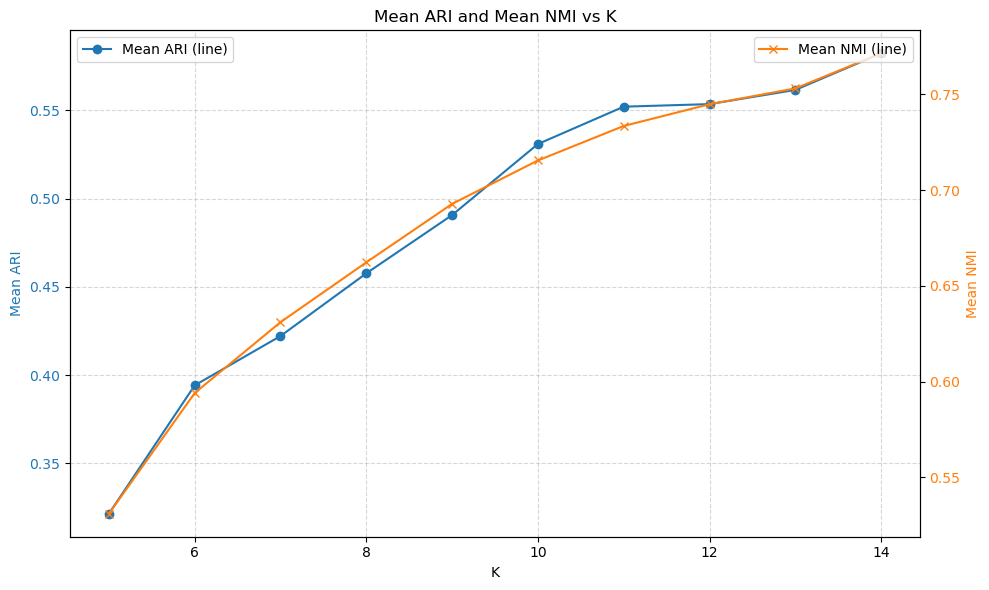

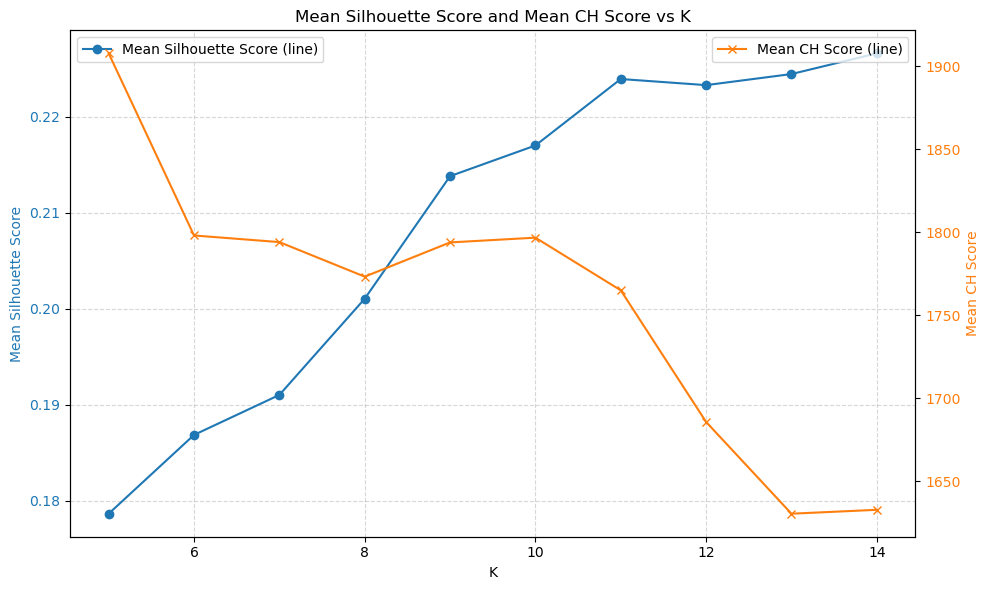

In [16]:
plot_two_axes(external_metric_df, x_col='K', y1_col='Mean ARI', y2_col='Mean NMI')
plot_two_axes(internal_metric_df, x_col='K', y1_col='Mean Silhouette Score', y2_col='Mean CH Score')

In [17]:
model = KMeans(n_clusters=10, n_init="auto")
pred = model.fit_predict(X)
cluster_labels = pd.Series(pred).astype("category").rename("Cluster labels")
cluster_labels

0        7
1        3
2        2
3        7
4        3
        ..
12380    3
12381    8
12382    2
12383    3
12384    7
Name: Cluster labels, Length: 12385, dtype: category
Categories (10, int32): [0, 1, 2, 3, ..., 6, 7, 8, 9]

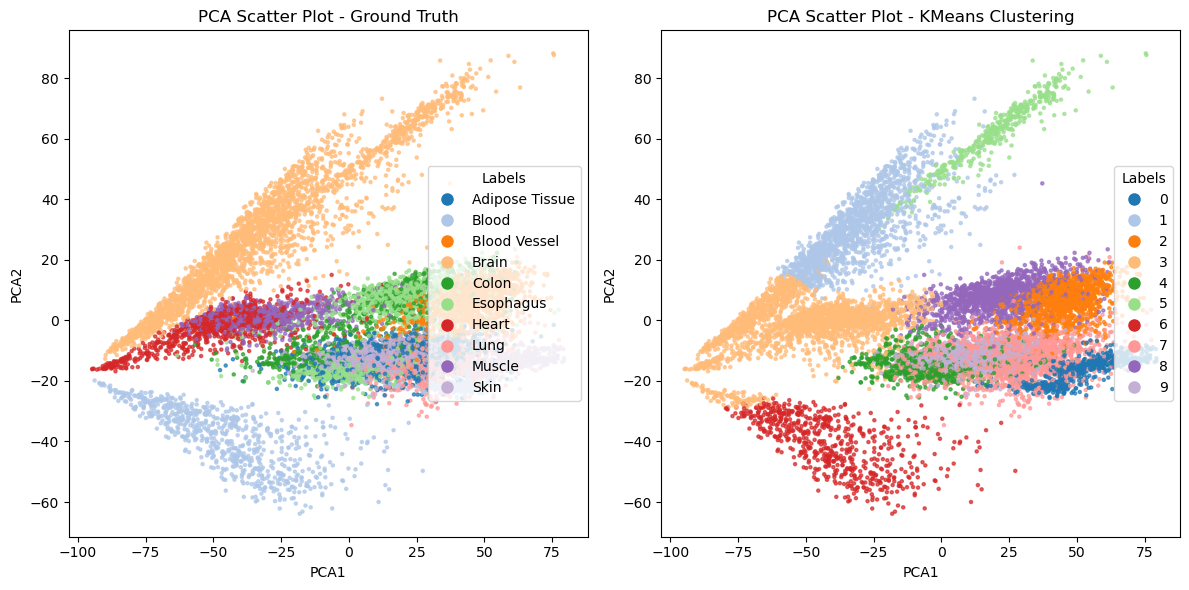

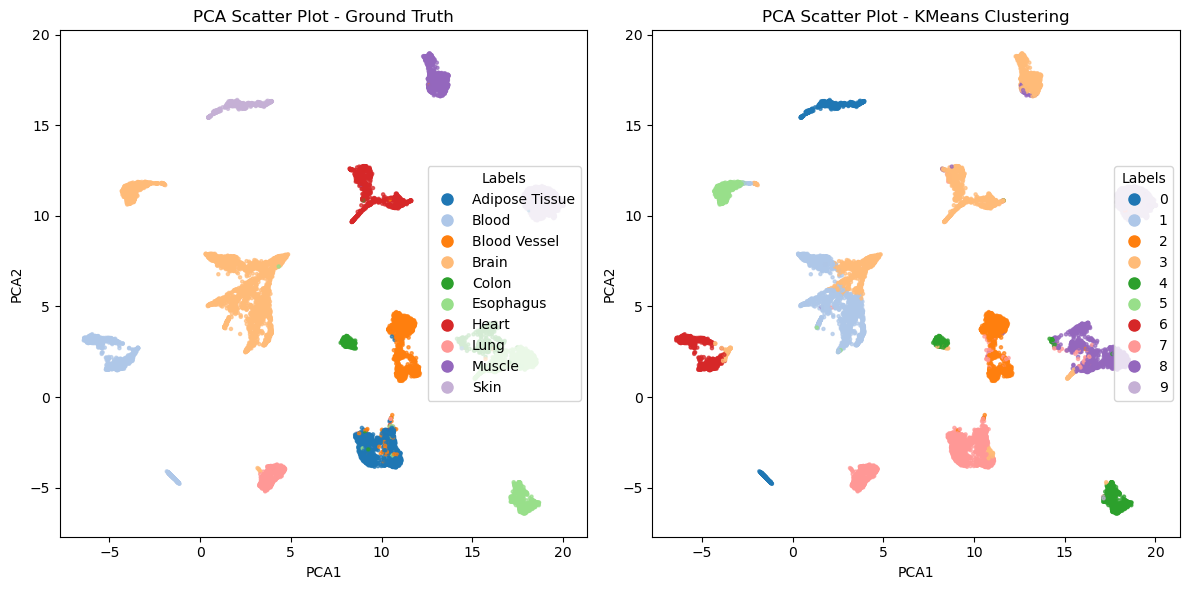

In [18]:
plot_pca_with_labels(
    features_pca,
    labels_list=[y.values, cluster_labels],
    titles=["PCA Scatter Plot - Ground Truth", "PCA Scatter Plot - KMeans Clustering"],
)

plot_pca_with_labels(
    features_umap,
    labels_list=[y.values, cluster_labels],
    titles=["PCA Scatter Plot - Ground Truth", "PCA Scatter Plot - KMeans Clustering"],
)

In [19]:
clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X, pred)

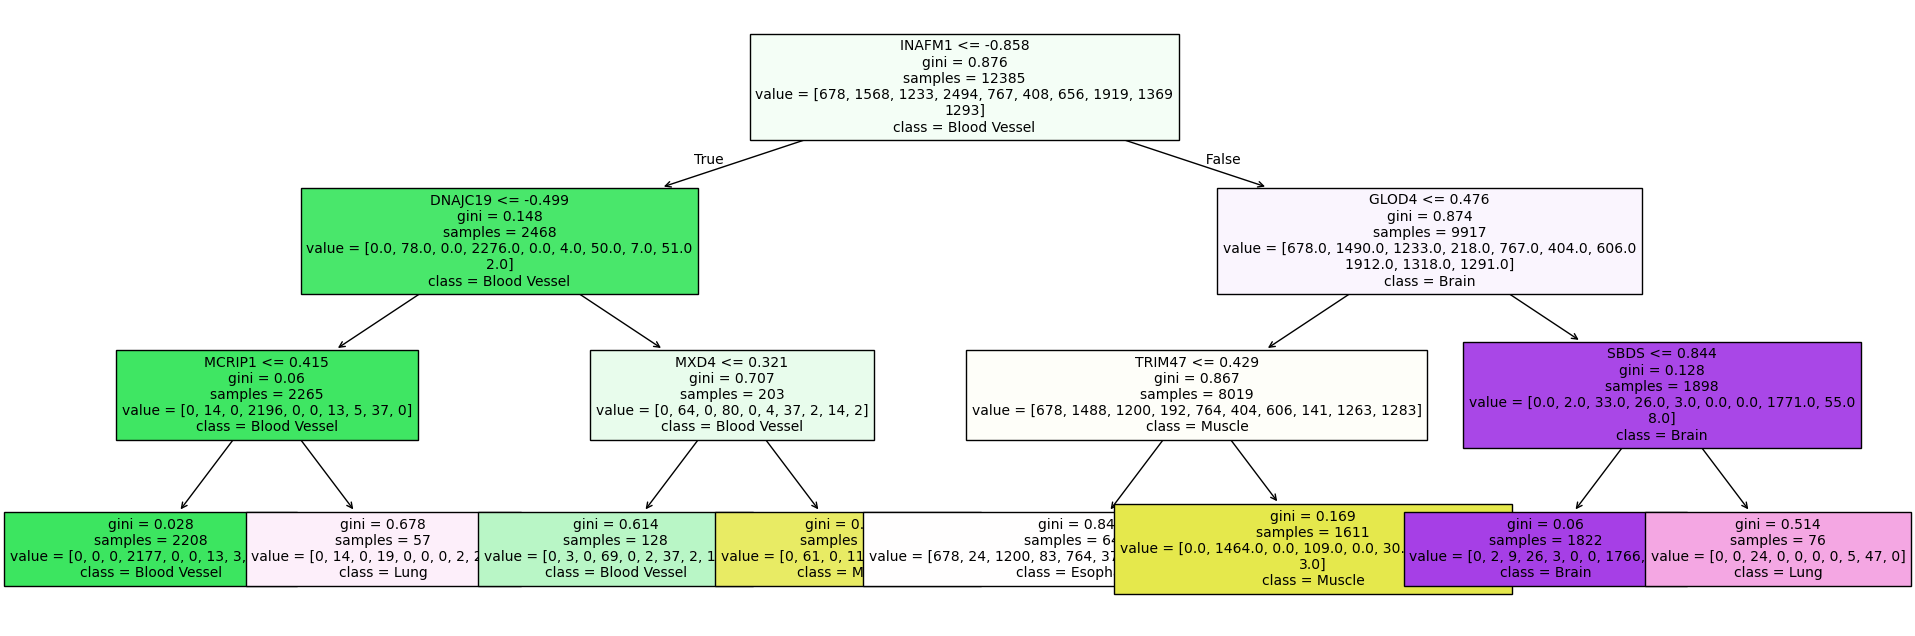

In [20]:
fig = plt.figure(figsize=(24, 8))
_ = plot_tree(
    clt,
    filled=True,
    fontsize=10,
    feature_names=feature_to_symbol.astype(str).iloc[:,0].tolist(),
    class_names=y.values
)

### Hierarchical clustering

In [21]:
from sklearn.cluster import AgglomerativeClustering

np.random.seed(0)
Ks = range(5, 15)
n_reps = 5

mean_aris_agg = []
mean_nmis_agg = []
mean_sils_agg = []
mean_chs_agg = []

for k in Ks:
    print(f"Running Hierarchical clustering with k = {k} ...")
    model = AgglomerativeClustering(n_clusters=k)
    label_pred = model.fit_predict(X)

    mean_aris_agg.append(ari(
        label_pred,
        y.values
    ))
    mean_nmis_agg.append(nmi(
        label_pred,
        y.values
    ))
    mean_sils_agg.append(silhouette_score(
        X,
        label_pred
    ))
    mean_chs_agg.append(calinski_harabasz_score(
        X,
        label_pred
    ))

Running Hierarchical clustering with k = 5 ...
Running Hierarchical clustering with k = 6 ...
Running Hierarchical clustering with k = 7 ...
Running Hierarchical clustering with k = 8 ...
Running Hierarchical clustering with k = 9 ...
Running Hierarchical clustering with k = 10 ...
Running Hierarchical clustering with k = 11 ...
Running Hierarchical clustering with k = 12 ...
Running Hierarchical clustering with k = 13 ...
Running Hierarchical clustering with k = 14 ...


In [22]:
external_metric_agg_df = pd.DataFrame(
    {
        "K": list(Ks),
        "Mean ARI": mean_aris_agg,
        "Mean NMI": mean_nmis_agg
    }
)

internal_metric_agg_df = pd.DataFrame(
    {
        "K": list(Ks),
        "Mean SIL": mean_sils_agg,
        "Mean CH": mean_chs_agg
    }
)

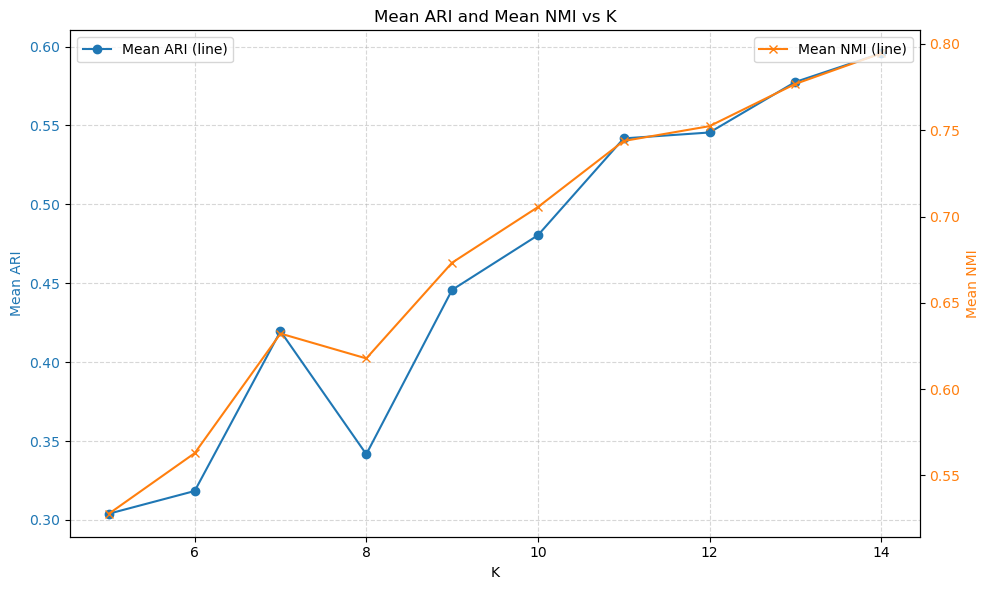

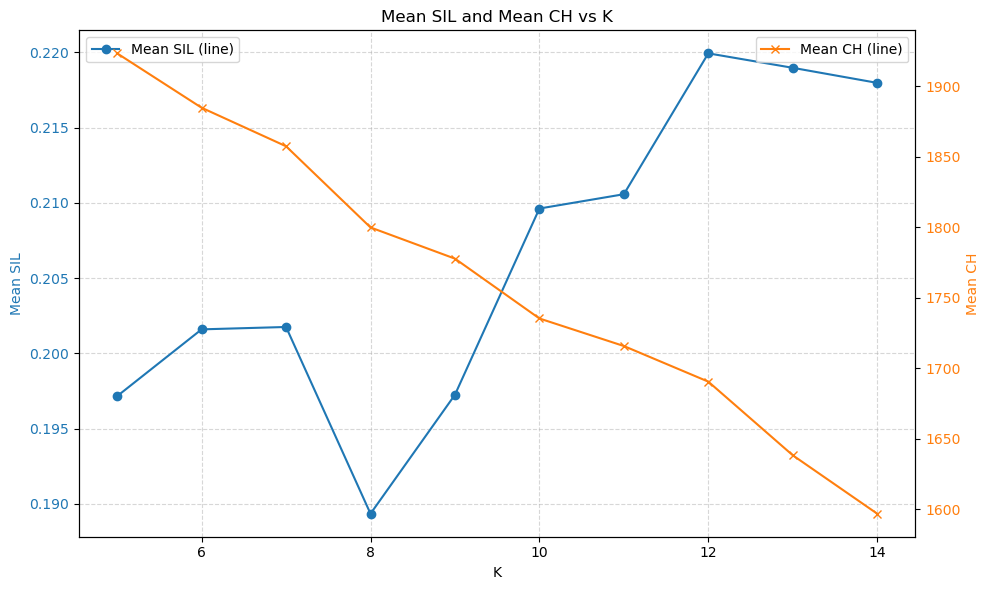

In [23]:
plot_two_axes(external_metric_agg_df, x_col='K', y1_col='Mean ARI', y2_col='Mean NMI')
plot_two_axes(internal_metric_agg_df, x_col='K', y1_col='Mean SIL', y2_col='Mean CH')

In [24]:
model = AgglomerativeClustering(n_clusters=12)
pred = model.fit_predict(X)
cluster_labels = pd.Series(pred).astype("category").rename("Cluster labels")
cluster_labels

0         3
1         9
2         4
3         3
4         2
         ..
12380     2
12381    10
12382     4
12383     9
12384     3
Name: Cluster labels, Length: 12385, dtype: category
Categories (12, int64): [0, 1, 2, 3, ..., 8, 9, 10, 11]

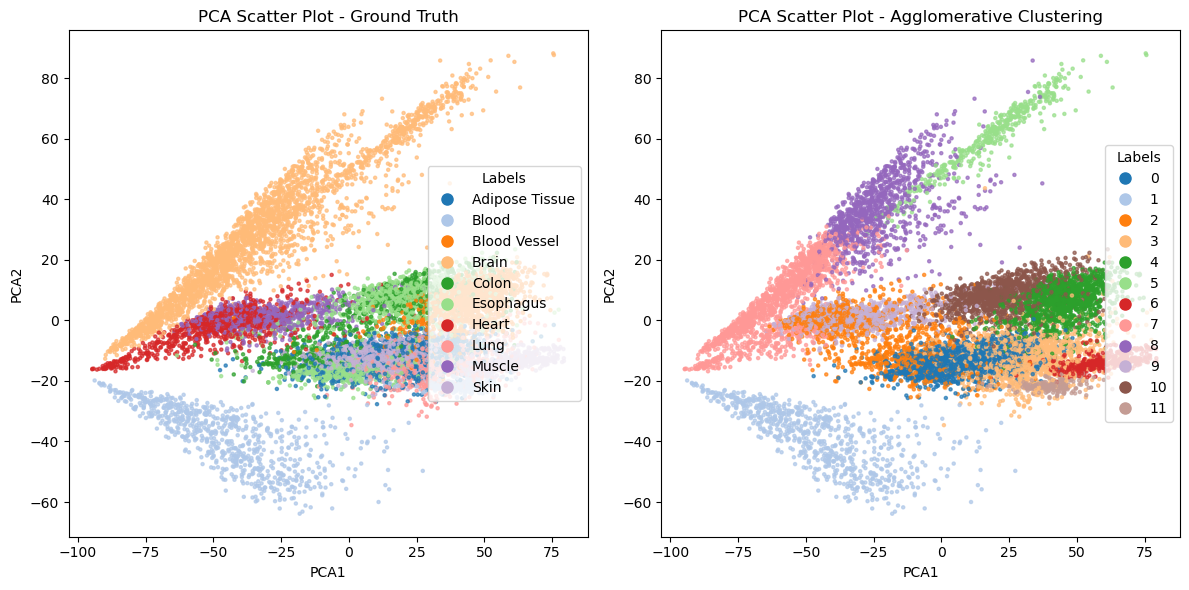

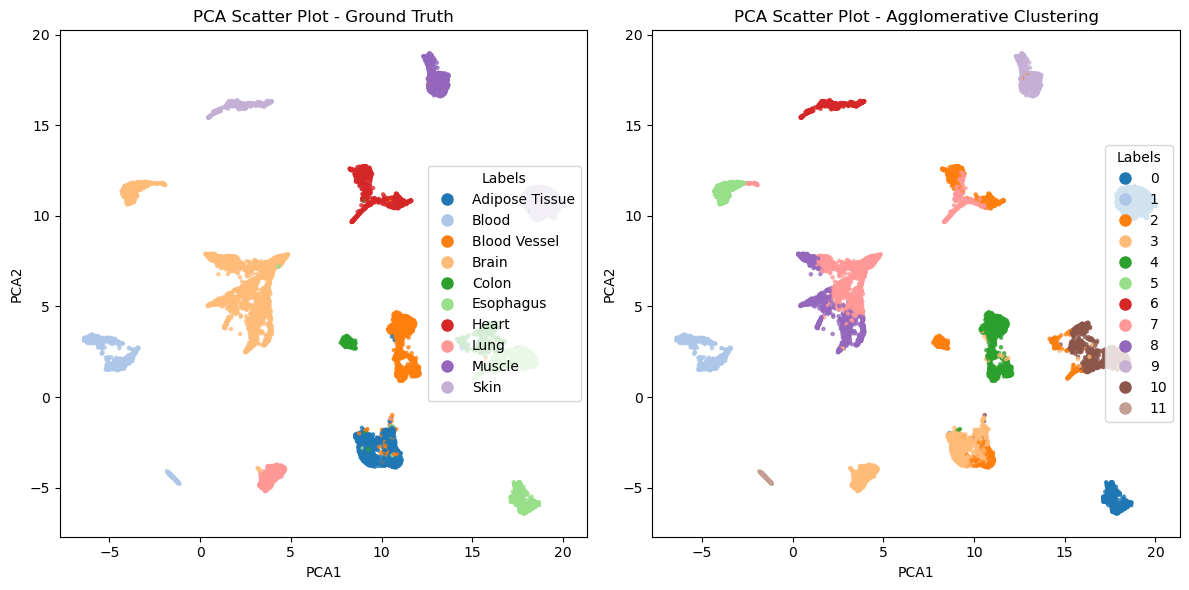

In [25]:
plot_pca_with_labels(
    features_pca,
    labels_list=[y.values, cluster_labels],
    titles=["PCA Scatter Plot - Ground Truth", "PCA Scatter Plot - Agglomerative Clustering"],
)

plot_pca_with_labels(
    features_umap,
    labels_list=[y.values, cluster_labels],
    titles=["PCA Scatter Plot - Ground Truth", "PCA Scatter Plot - Agglomerative Clustering"],
)

In [26]:
clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X, pred)

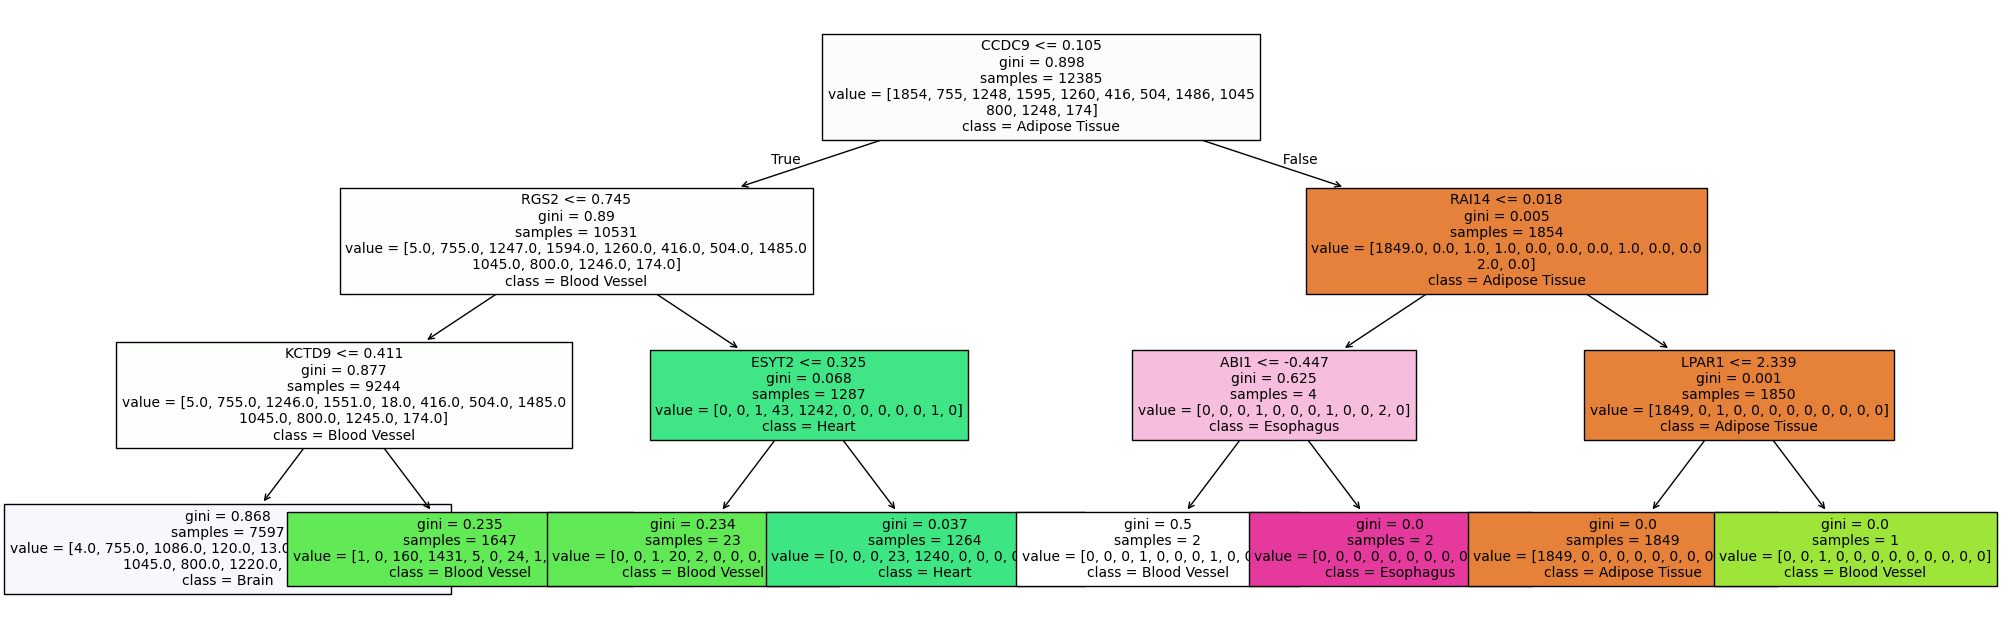

In [27]:
fig = plt.figure(figsize=(24, 8))
_ = plot_tree(
    clt,
    filled=True,
    fontsize=10,
    feature_names=feature_to_symbol.astype(str).iloc[:,0].tolist(),
    class_names=y.values
)

## Exploration of genes driving tissue classification

In [28]:
clt_truth = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X, y)

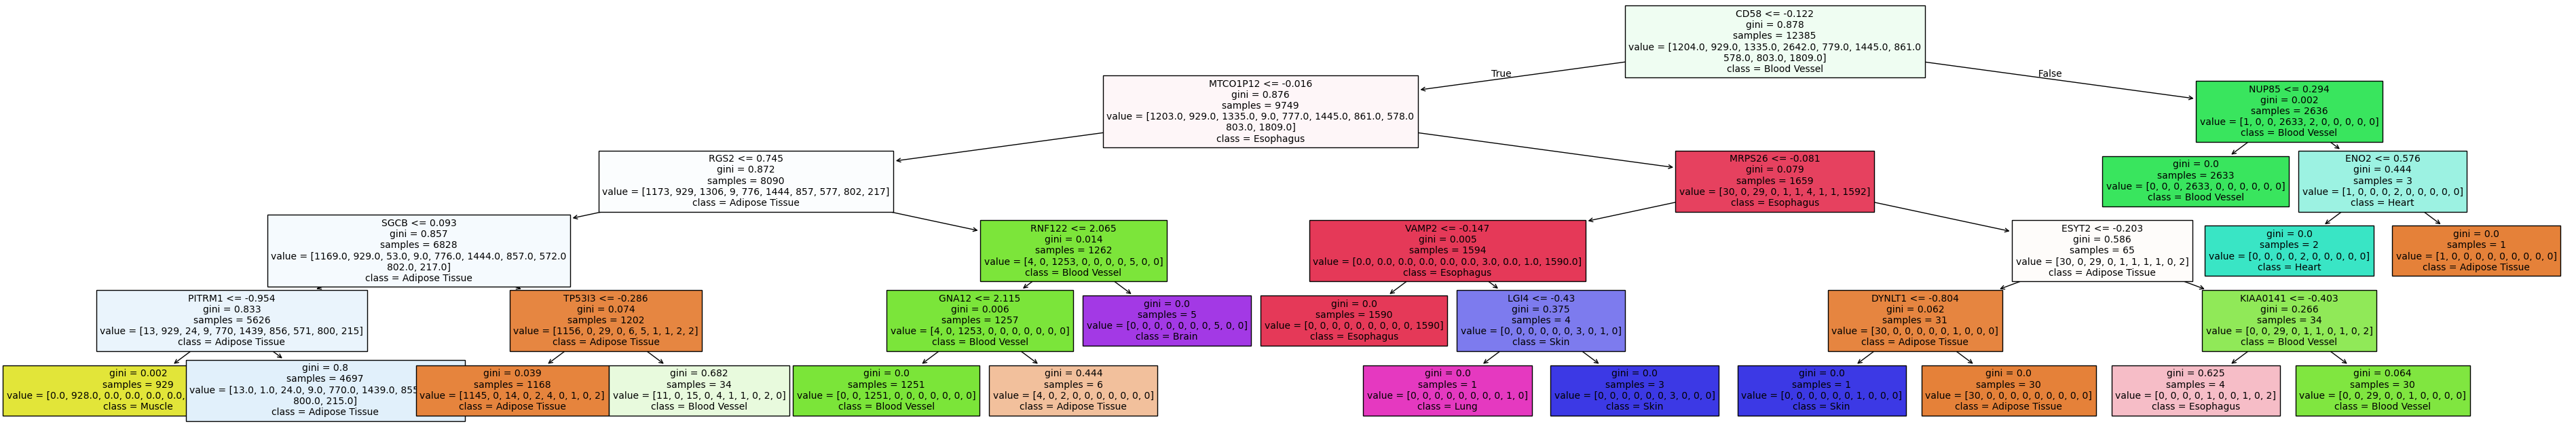

In [29]:
fig = plt.figure(figsize=(48, 8))
_ = plot_tree(
    clt_truth,
    filled=True,
    fontsize=10,
    feature_names=feature_to_symbol.astype(str).iloc[:,0].tolist(),
    class_names=y.values
)